In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math

2023-11-16 19:29:02.796172: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 19:29:02.847863: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:29:03.117504: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:29:03.119000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 19:29:04.322238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
def parse_jsonl(path: str) -> pd.DataFrame:
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    return pd.DataFrame(data)

# data explortion

In [3]:
train_df = pd.read_json("./data/train.jsonl", lines=True)
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1


In [4]:
train_df = (parse_jsonl("./data/train.jsonl"))
test_df = (parse_jsonl("./data/test.jsonl"))
validation_df = (parse_jsonl("./data/validation.jsonl"))

In [5]:
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0,1,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0,1,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0,1,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0,1,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0,1,0


# NONANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value 

In [6]:
round(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index), 4) * 100

8.43

I think we can ignore this for now since the main columns i think we will be using are `messages` and `sender_labels`

If we do need it in the future, we can omit it only losing 8.43% of the rows.

# Unique Words

In [7]:
each_message_words = train_df['messages'].str.lower().str.findall("\w+")
unique_words = set(each_message_words.sum())
list(sorted(unique_words))

['0',
 '01',
 '02',
 '03',
 '05',
 '08',
 '1',
 '10',
 '100',
 '1000',
 '100000',
 '10pm',
 '11',
 '110',
 '11th',
 '12',
 '13',
 '13199396',
 '13hrs',
 '14',
 '15',
 '16',
 '17',
 '18',
 '1901',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1907',
 '1908',
 '1909',
 '1910',
 '1914',
 '1a',
 '1b',
 '1st',
 '1v1',
 '2',
 '20',
 '200',
 '2003',
 '2014',
 '25',
 '250',
 '26',
 '2a',
 '2am',
 '2b',
 '2c',
 '2v1',
 '3',
 '30',
 '30a',
 '30p',
 '3575755',
 '358278238675664896',
 '36',
 '3a',
 '3b',
 '3v2',
 '3x',
 '4',
 '40',
 '45',
 '4d',
 '4v2',
 '4v3',
 '5',
 '50',
 '530',
 '5538733581926400',
 '5637073032183808',
 '567829259054219275',
 '5727111032078336',
 '5th',
 '6',
 '601857887098372112',
 '613143739954888734',
 '61940739',
 '6203125562605568',
 '6340894809128960',
 '7',
 '730am',
 '730ish',
 '730pm',
 '7449927',
 '7p',
 '8',
 '8th',
 '9',
 '94',
 '945',
 '95',
 '9pm',
 '_',
 '_____',
 '_and',
 '_anything_',
 '_us_',
 'a',
 'aaaaaalllllllllll',
 'aaaaany',
 'aars',
 'aassume',
 'aba

In [8]:
len(unique_words)

7790

I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted.

After processing, we have a total of 7,790 words.

Some things to note are
- there are some arbitrary number included
- some words are wrapped with markdown characters like `**` or `__` for emphasis in the conversation
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

<Axes: >

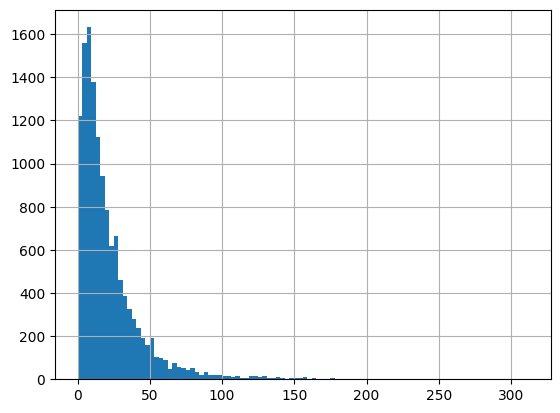

In [9]:
each_message_words.map(len).hist(bins=100)

In [32]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(train_df['messages'].map(len)) / len(train_df.index)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,13132.00000
1,Average words per message,107.50929
2,Unique word count,7790.00000
3,Actual Lie count,591.00000
4,Actual Truth count,12541.00000
